# 앙상블 코드 정리

In [1]:
import numpy as np
import pandas as pd

# 1. 각 모델 결과 불러오기

In [2]:
deep = pd.read_csv('epo5_result_df.csv')
rf = np.load('RF_predprob.npy')
lgbm = np.load('LGB_predprob.npy')

In [3]:
result = deep.loc[:, ['True_Labels', 'Probability_1']]
result.rename(columns={'Probability_1': 'deep'}, inplace=True)

In [4]:
result['rf'] = rf
result['lgbm'] = lgbm

In [5]:
result['avg'] = (result['deep']+result['rf']+result['lgbm'])/3     # 앙상블 열

In [6]:
# 디폴트 예측
result['predict'] = 0
result.loc[result['avg']>0.5, 'predict'] = 1    # 더 큰값으로 분류

* 각 모델 결과(사무 1확률) 확인

In [7]:
result

,True_Labels,deep,rf,lgbm,avg,predict
0,0,0.028129,0.04,0.018466,0.028865,0
1,0,0.113840,0.00,0.002707,0.038849,0
2,0,0.041808,0.00,0.001332,0.014380,0
3,0,0.389585,0.00,0.010680,0.133422,0
4,0,0.621263,0.19,0.048522,0.286595,0
...,...,...,...,...,...,...
172320,0,0.006937,0.00,0.001703,0.002880,0
172321,0,0.629046,0.03,0.044869,0.234638,0
172322,0,0.014054,0.00,0.001915,0.005323,0
172323,1,0.630495,0.67,0.514004,0.604833,1


In [8]:
result.loc[result['True_Labels']==0, ].describe()

,True_Labels,deep,rf,lgbm,avg,predict
count,160320.0,160320.000000,160320.000000,160320.000000,160320.000000,160320.000000
mean,0.0,0.266082,0.043691,0.044548,0.118107,0.021744
std,0.0,0.258561,0.121256,0.104946,0.132973,0.145847
min,0.0,0.002595,0.000000,-0.022201,0.002631,0.000000
25%,0.0,0.029858,0.000000,0.002205,0.011867,0.000000
50%,0.0,0.168876,0.000000,0.005221,0.067861,0.000000
75%,0.0,0.485648,0.020000,0.033232,0.194122,0.000000
max,0.0,0.974354,1.000000,0.872750,0.925068,1.000000


In [9]:
result.loc[result['True_Labels']==1, ].describe()

,True_Labels,deep,rf,lgbm,avg,predict
count,12005.0,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000
mean,1.0,0.607077,0.443960,0.393382,0.481473,0.495877
std,0.0,0.171042,0.308759,0.246633,0.196169,0.500004
min,1.0,0.006812,0.000000,0.001332,0.003101,0.000000
25%,1.0,0.512234,0.155000,0.143736,0.319139,0.000000
50%,1.0,0.635645,0.430000,0.433675,0.497790,0.000000
75%,1.0,0.729502,0.710000,0.611887,0.643833,1.000000
max,1.0,0.962729,1.000000,0.878286,0.933236,1.000000


# 2. 디폴트 예측 앙상블 결과 확인

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def cal_result(preds, y):
    conf_matrix = confusion_matrix(y, preds)
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    
    return accuracy, recall

def cal_result2(preds, y):
    conf_matrix = confusion_matrix(y, preds)
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    
    # 결과 출력
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    return conf_matrix

In [11]:
cal_result2(result['predict'], result['True_Labels'])    # 앙상블 기본 threshold 결과

Accuracy: 0.9446510953140868
Precision: 0.6306812162305329
Recall: 0.49587671803415245
F1-Score: 0.555213579556053
Confusion Matrix:
[[156834   3486]
 [  6052   5953]]


array([[156834,   3486],
       [  6052,   5953]])

# 3. threshold 조정

In [12]:
def check_threshold(x, y_acc, y_rec, result, col):
    for i in x:
        threshold = i
        result['predict'] = 0
        result.loc[result[col]>threshold, 'predict'] = 1
        acc, rec = cal_result(result['predict'], result['True_Labels'])
        y_acc.append(acc)
        y_rec.append(rec)
        
    return y_acc, y_rec

In [13]:
x = np.arange(0.01, 0.51, 0.01)

rf_y_acc = []
rf_y_rec = []
deep_y_acc = []
deep_y_rec = []
lgbm_y_acc = []
lgbm_y_rec = []
avg_y_acc = []
avg_y_rec = []

# 모델별 acuuracy, recall 저장
rf_y_acc, rf_y_rec = check_threshold(x, rf_y_acc, rf_y_rec, result, 'rf')
deep_y_acc, deep_y_rec = check_threshold(x, deep_y_acc, deep_y_rec, result, 'deep')
lgbm_y_acc, lgbm_y_rec = check_threshold(x, lgbm_y_acc, lgbm_y_rec, result, 'lgbm')
avg_y_acc, avg_y_rec = check_threshold(x, avg_y_acc, avg_y_rec, result, 'avg')

* 모델 별 accuracy, recall 비교 그래프

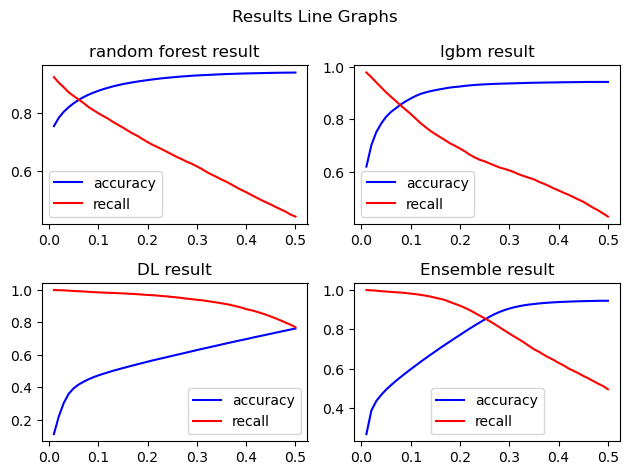

In [14]:
import matplotlib.pyplot as plt

# 2x2 그래프 생성
plt.subplot(2, 2, 1)
plt.plot(x, rf_y_acc, label='accuracy', color='blue')
plt.plot(x, rf_y_rec, label='recall', color='red')
plt.title('random forest result')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x, lgbm_y_acc, label='accuracy', color='blue')
plt.plot(x, lgbm_y_rec, label='recall', color='red')
plt.title('lgbm result')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x, deep_y_acc, label='accuracy', color='blue')
plt.plot(x, deep_y_rec, label='recall', color='red')
plt.title('DL result')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(x, avg_y_acc, label='accuracy', color='blue')
plt.plot(x, avg_y_rec, label='recall', color='red')
plt.title('Ensemble result')
plt.legend()

# 그래프에 제목과 축 레이블 추가
plt.suptitle('Results Line Graphs')
plt.tight_layout()  # 서브플롯 간 간격 조절

# 그래프 표시
plt.show()

## accuracy, recall 1:1 비율 최적의 threshold 확인

In [15]:
rf_result = np.sum([rf_y_acc, rf_y_rec], axis=0)
deep_result = np.sum([deep_y_acc, deep_y_rec], axis=0)
lgbm_result = np.sum([lgbm_y_acc, lgbm_y_rec], axis=0)
avg_result = np.sum([avg_y_acc, avg_y_rec], axis=0)

print("====== accuracy, recall 1:1 비율 최적의 threshold =========")
print("위치: ",np.argmax(rf_result), np.argmax(deep_result), np.argmax(lgbm_result), np.argmax(avg_result))
print("임계치값: ", x[2], x[36], x[5], x[25])
print("최대값: ", rf_result[2], deep_result[36], lgbm_result[5], avg_result[25])

====== accuracy, recall 1:1 비율 최적의 threshold =========
위치:  2 36 5 25
임계치값:  0.03 0.37 0.06 0.26
최대값:  1.6958764956789065 1.5833042533356156 1.71489993923297 1.7053350552169104


In [16]:
print('====== rf threshold = 0.03======')
threshold = 0.03
result['predict'] = 0
result.loc[result['rf']>threshold, 'predict'] = 1
a = cal_result2(result['predict'], result['True_Labels'])

print('====== deep threshold = 0.37======')
threshold = 0.37
result['predict'] = 0
result.loc[result['deep']>threshold, 'predict'] = 1
b = cal_result2(result['predict'], result['True_Labels'])

print('====== lgbm threshold = 0.06======')
threshold = 0.06
result['predict'] = 0
result.loc[result['lgbm']>threshold, 'predict'] = 1
b = cal_result2(result['predict'], result['True_Labels'])

print('====== avg threshold = 0.02======')
threshold = 0.26
result['predict'] = 0
result.loc[result['avg']>threshold, 'predict'] = 1
b = cal_result2(result['predict'], result['True_Labels'])

====== rf threshold = 0.03======
Accuracy: 0.8054141883069781
Precision: 0.24914349639918895
Recall: 0.8904623073719283
F1-Score: 0.38935023310023315
Confusion Matrix:
[[128103  32217]
 [  1315  10690]]
====== deep threshold = 0.37======
Accuracy: 0.6770985057304512
Precision: 0.16635319662981482
Recall: 0.9062057476051645
F1-Score: 0.28110384744580247
Confusion Matrix:
[[105802  54518]
 [  1126  10879]]
====== lgbm threshold = 0.06======
Accuracy: 0.8288524590163935
Precision: 0.2744182446726175
Recall: 0.8860474802165764
F1-Score: 0.4190517462130912
Confusion Matrix:
[[132195  28125]
 [  1368  10637]]
====== avg threshold = 0.02======
Accuracy: 0.8637690410561439
Precision: 0.3189380307478612
Recall: 0.8415660141607664
F1-Score: 0.46257039512842824
Confusion Matrix:
[[138746  21574]
 [  1902  10103]]


## accuracy, recall 1:2 비율 최적의 threshold 확인

In [17]:
rf_result2 = np.sum([rf_y_acc, np.array(rf_y_rec)*2], axis=0)
deep_result2 = np.sum([deep_y_acc, np.array(deep_y_rec)*2], axis=0)
lgbm_result2 = np.sum([lgbm_y_acc, np.array(lgbm_y_rec)*2], axis=0)
avg_result2 = np.sum([avg_y_acc, np.array(avg_y_rec)*2], axis=0)

print("====== accuracy, recall 1:2 비율 최적의 threshold =========")
print("위치: ",np.argmax(rf_result2), np.argmax(deep_result2), np.argmax(lgbm_result2), np.argmax(avg_result2))
print("임계치값: ", x[0], x[30], x[2], x[16])
print("최대값: ", rf_result2[0], deep_result2[30], lgbm_result2[2], avg_result2[16])

====== accuracy, recall 1:2 비율 최적의 threshold =========
위치:  0 30 2 16
임계치값:  0.01 0.31 0.03 0.17
최대값:  2.6070843662328667 2.5091515969124765 2.6338171296076704 2.61807193711842


In [18]:
print('====== rf threshold = 0.01======')
threshold = 0.01
result['predict'] = 0
result.loc[result['rf']>threshold, 'predict'] = 1
a = cal_result2(result['predict'], result['True_Labels'])

print('====== deep threshold = 0.31======')
threshold = 0.31
result['predict'] = 0
result.loc[result['deep']>threshold, 'predict'] = 1
b = cal_result2(result['predict'], result['True_Labels'])

print('====== lgbm threshold = 0.03======')
threshold = 0.03
result['predict'] = 0
result.loc[result['lgbm']>threshold, 'predict'] = 1
b = cal_result2(result['predict'], result['True_Labels'])

print('====== avg threshold = 0.17======')
threshold = 0.17
result['predict'] = 0
result.loc[result['avg']>threshold, 'predict'] = 1
b = cal_result2(result['predict'], result['True_Labels'])

====== rf threshold = 0.01======
Accuracy: 0.7551893225010881
Precision: 0.21208074178654557
Recall: 0.9259475218658892
F1-Score: 0.3451155714928825
Confusion Matrix:
[[119022  41298]
 [   889  11116]]
====== deep threshold = 0.31======
Accuracy: 0.6359321050340926
Precision: 0.15356250256074078
Recall: 0.936609745939192
F1-Score: 0.2638631403562293
Confusion Matrix:
[[98343 61977]
 [  761 11244]]
====== lgbm threshold = 0.03======
Accuracy: 0.7514347889162919
Precision: 0.21148482976772043
Recall: 0.9411911703456893
F1-Score: 0.34536618168480254
Confusion Matrix:
[[118192  42128]
 [   706  11299]]
====== avg threshold = 0.17======
Accuracy: 0.7223618163354127
Precision: 0.19419082888202469
Recall: 0.9478550603915036
F1-Score: 0.32234214328205996
Confusion Matrix:
[[113102  47218]
 [   626  11379]]
